In [1]:
import numpy as np
import numpy.random as nrd
import numpy.linalg as nla
import matplotlib.pyplot as plt

from collections import defaultdict

from csaps import csaps
from sklearn.linear_model import LinearRegression

# Exercise 11.6

Write a program to carry out projection pursuit regression, using
cubic smoothing splines with fixed degrees of freedom. Fit it to the data
from the previous exercise, for various values of the smoothing parameter
and number of model terms. Find the minimum number of model terms
necessary for the model to perform well and compare this to the number
of hidden units from the previous exercise.

# Solution

The Projection Pursue Regression algorithm as described in Chp 11 of the main text,

In [2]:
class ProjectionsPursueRegression():
    
    def __init__(self,terms,smoothing):
        self.M = terms
        self.smt_param = smoothing
        
        self.use_validation = False
        
    def add_validation_set(self,X,y):
        self.use_validation = True
        
        self.X_val = X
        self.y_val = y
    
    # We need this since the V vector is not sorted
    def __univariate_spline(self,X,y):
        sort_index = np.argsort(X)
        X_sort = X[sort_index]
        y_sort = y[sort_index]
        
        return csaps(X_sort,y_sort,smooth=1-self.smt_param)
    
    def fit_single_term(self,X,y,conv_prec,max_iters):
        
        omega = nrd.rand(self.p)
        prev_loss = np.inf
        iters=0
        
        while True:
            
            # Normalize the direction and compute projection
            omega = omega/nla.norm(omega)
            V = omega @ X.T
            
            # Find smooth function fitting the data
            g = self.__univariate_spline(V,y)
                        
            # Check convergence
            loss = np.mean((y - g(omega @ X.T))**2)
            
            if abs(loss-prev_loss)<conv_prec or iters == max_iters:
                break
                
            # Find direction via linear regression (no bias)
            target = V + (y - g(V))/g(V,nu=1)
            reg = LinearRegression(fit_intercept=False)
            reg.fit(X,target)
            omega = reg.coef_
                
            prev_loss = loss
            iters += 1
        
        return g, omega

    def fit(self,X,y,conv_prec=1e-4,max_iters=100):
        
        self.N, self.p = X.shape
        target = y.copy()
        
        self.directions = []
        self.splines = []
        self.history = defaultdict(list)
        
        for _ in range(self.M):
            
            # Find additive term for the model, and store it
            g, omega = self.fit_single_term(X,target,conv_prec,max_iters)
            self.directions.append(omega)
            self.splines.append(g)
            
            # Update the target in a forward stage-wise fashion
            target -= g(omega @ X.T)
            
            # Compute loss function (and validation loss if validation given)
            self.history['train_loss'].append(self.loss(X,y))
            
            if self.use_validation:
                self.history['val_loss'].append(self.loss(self.X_val,self.y_val))
            
    def predict(self,X):
        y_predict = 0
        for g,omega in zip(self.splines,self.directions):
            y_predict += g(omega @ X.T)
        return y_predict
    
    def loss(self,X,y):
        return np.mean((y - self.predict(X))**2)    

### Data

Here we create the data and plot the response as a function of the predictors

In [3]:
def sigmoid(X):
    return 1/(1+np.exp(-X))

def y_dependence(X):
    N,_ = X.shape
    
    a1 = np.array([3,3])
    a2 = np.array([3,-3])
    
    epsilon = nrd.normal(size=N)
    c1 = 0.3

    return sigmoid(X @ a1) + (X @ a2)**2 + c1 * epsilon

The response looks like this,

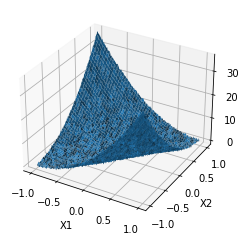

In [4]:
X_line = np.arange(-1,1,0.01)
X1,X2 = np.meshgrid(X_line,X_line)

Z = []
for x2 in X_line:
    X_coord = np.array([[x1,x2] for x1 in X_line])
    Z.append(y_dependence(X_coord))
Z = np.array(Z)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Z)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

Create the training data and the validation,

In [5]:
N_train = 100
N_val = 1000
p = 2

# Training set
X_train = nrd.normal(size=(N_train,p))
y_train = y_dependence(X_train)

# Test set
X_val = nrd.normal(size=(N_val,p))
y_val = y_dependence(X_val)

Let's check different smoothing parameters, and different number of terms in the model,

PPR with smoothing = 0.30


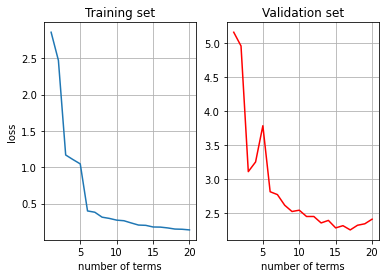

PPR with smoothing = 0.10


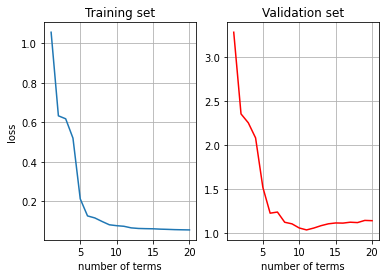

PPR with smoothing = 0.03


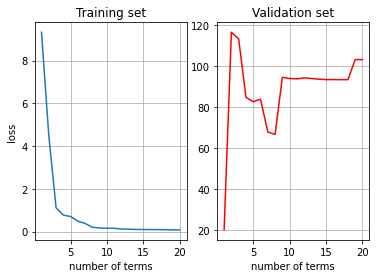

PPR with smoothing = 0.01


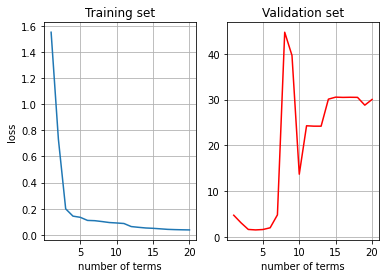

In [6]:
M = 20
smoothing = [0.3,0.1,0.03,0.01]
terms = [i+1 for i in range(M)]

for smt in smoothing:
    
    ppr = ProjectionsPursueRegression(M,smt)
    ppr.add_validation_set(X_val,y_val)
    ppr.fit(X_train,y_train)
    
    print('PPR with smoothing = {:.2f}'.format(smt))
    
    plt.subplot(121)
    plt.plot(terms,ppr.history['train_loss'])
    plt.title('Training set')
    plt.xlabel('number of terms')
    plt.ylabel('loss')
    plt.grid()
    
    plt.subplot(122)
    plt.plot(terms,ppr.history['val_loss'],c='r')
    plt.title('Validation set')
    plt.xlabel('number of terms')
    plt.grid()

    plt.show()

Clearly, a smt parameter around 0.1 and a number of terms between 5 and 10 are enough to approximate the data well.

Here we look at the first few directions and smooth splines generated by the algorithm

Direction omega1 = (0.72,-0.70)


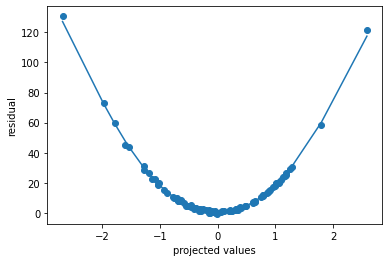

Direction omega2 = (-0.91,-0.42)


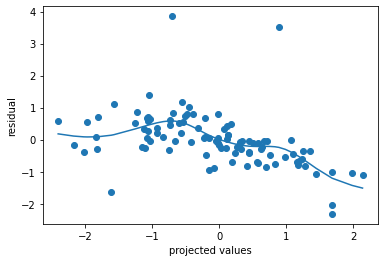

Direction omega3 = (-0.62,0.78)


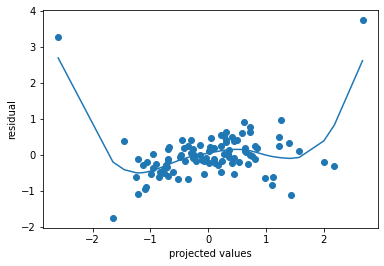

In [9]:
# The optimal parameters estimated above
M = 10
smt = 0.1

ppr = ProjectionsPursueRegression(M,smt)
ppr.fit(X_train,y_train)

target = y_train.copy()

for i in range(3):
    
    g = ppr.splines[i]
    omega = ppr.directions[i]
    
    print('Direction omega{} = ({:.2f},{:.2f})'.format(i+1,*omega))
    
    V = omega @ X_train.T
    V_sorted = sorted(V)
    
    plt.scatter(V,target)
    plt.plot(V_sorted,g(V_sorted))
    plt.xlabel('projected values')
    plt.ylabel('residual')
    plt.show()
    
    target -= g(V)
    